# Main imports

### Native imports

In [1]:
import os
import pandas as pd
from datetime import date, datetime

### More imports

In [2]:
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, BatchNormalization

from keras.regularizers import l2
 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau




### own modules

In [3]:
from data_explorer import get_celebrities, get_tvt

# Load imatge classification

En un futur seria interesant crear una llibreria propia per a manejar les dades i poder agafar mostres en concret. En aquest cas estic agafant la part de validation perque conte totes les cares d'una mateix persona i per a fer proves i entrenar la xarxa és més ràpid.

In [4]:
identity_df = get_celebrities(5)
identity_df = shuffle(identity_df)
identity_df

,Image_name,Identity
130484,130485.jpg,2820
6828,006829.jpg,3699
173005,173006.jpg,3782
45996,045997.jpg,3699
175531,175532.jpg,3782
...,...,...
178573,178574.jpg,3782
54311,054312.jpg,3745
165036,165037.jpg,3782
163291,163292.jpg,3227


## Process data

In [5]:
TARGET = 3699
TARGET_COL_NAME = 'target'

In [6]:
identity_df['target'] = identity_df['Identity'] == TARGET
identity_df['target'] = identity_df['target'].astype(str)

### Training, validation and test dataframes

In [7]:
train_df, val_df, test_df = get_tvt(identity_df, "target", 0.8)

In [8]:
def print_params_tvt(train_df, val_df, test_df, traget_name):
    print(f"Train len: {len(train_df)}")
    print(train_df[traget_name].nunique())
    print(f"Val len: {len(val_df)}")
    print(val_df[traget_name].nunique())
    print(f"Test len: {len(test_df)}")
    print(test_df[traget_name].nunique())

In [9]:
print_params_tvt(train_df, val_df, test_df, "target")

Train len: 138
2
Val len: 17
2
Test len: 18
2


In [10]:
img_dir = "Imatges/CelebA/Img/img_align_celeba/img_align_celeba/"
img_size = (178,218)
batch_size = 4
epochs = 10

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col="Image_name",
    y_col=TARGET_COL_NAME,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse")

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col="Image_name",
    y_col=TARGET_COL_NAME,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="sparse")

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=img_dir,
    x_col="Image_name",
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=True,
)

Found 138 validated image filenames belonging to 2 classes.
Found 17 validated image filenames belonging to 2 classes.
Found 18 validated image filenames.


In [13]:
# model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-06, mode=0)) el mode=0 dona un error ja que es d'una versio anterior.
# He intentat buscar a quin argument correspon per actualitzar la funcio pero no he trobat cap
def prepare_model2():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape=(178, 218, 3), 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))    
    model.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))

    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    model.summary()
    return model



In [14]:
# https://github.com/hlamba28/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet-BHSig260.ipynb
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/weights_epoch_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [15]:
model = prepare_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 42, 52, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 25, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 24, 29, 96)       0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 20, 25, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 12, 256)       0         
 2D)                                                             
                                                        

In [16]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    callbacks = callbacks)


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.7461 - mae: 0.3413
Epoch 1: saving model to ./Weights\weights_epoch_001.h5
34/34 [==============================] - 8s 195ms/step - loss: 0.7461 - mae: 0.3413 - val_loss: 0.2745 - val_mae: 0.3382 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1539 - mae: 0.2228
Epoch 2: saving model to ./Weights\weights_epoch_002.h5
34/34 [==============================] - 6s 188ms/step - loss: 0.1539 - mae: 0.2228 - val_loss: 0.3653 - val_mae: 0.3787 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1682 - mae: 0.2332
Epoch 3: saving model to ./Weights\weights_epoch_003.h5
34/34 [==============================] - 7s 205ms/step - loss: 0.1682 - mae: 0.2332 - val_loss: 0.3228 - val_mae: 0.3968 - lr: 0.0010
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.1527 - mae: 0.2443
Epoch 4: saving model to ./Weights\weights_epoch_004.h5
34/34 [===========

In [17]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test mae:', score[1])

5/5 [==============================] - 0s 64ms/step - loss: 0.2794 - mae: 0.3930
Test loss: 0.2793619930744171
Test mae: 0.39301273226737976


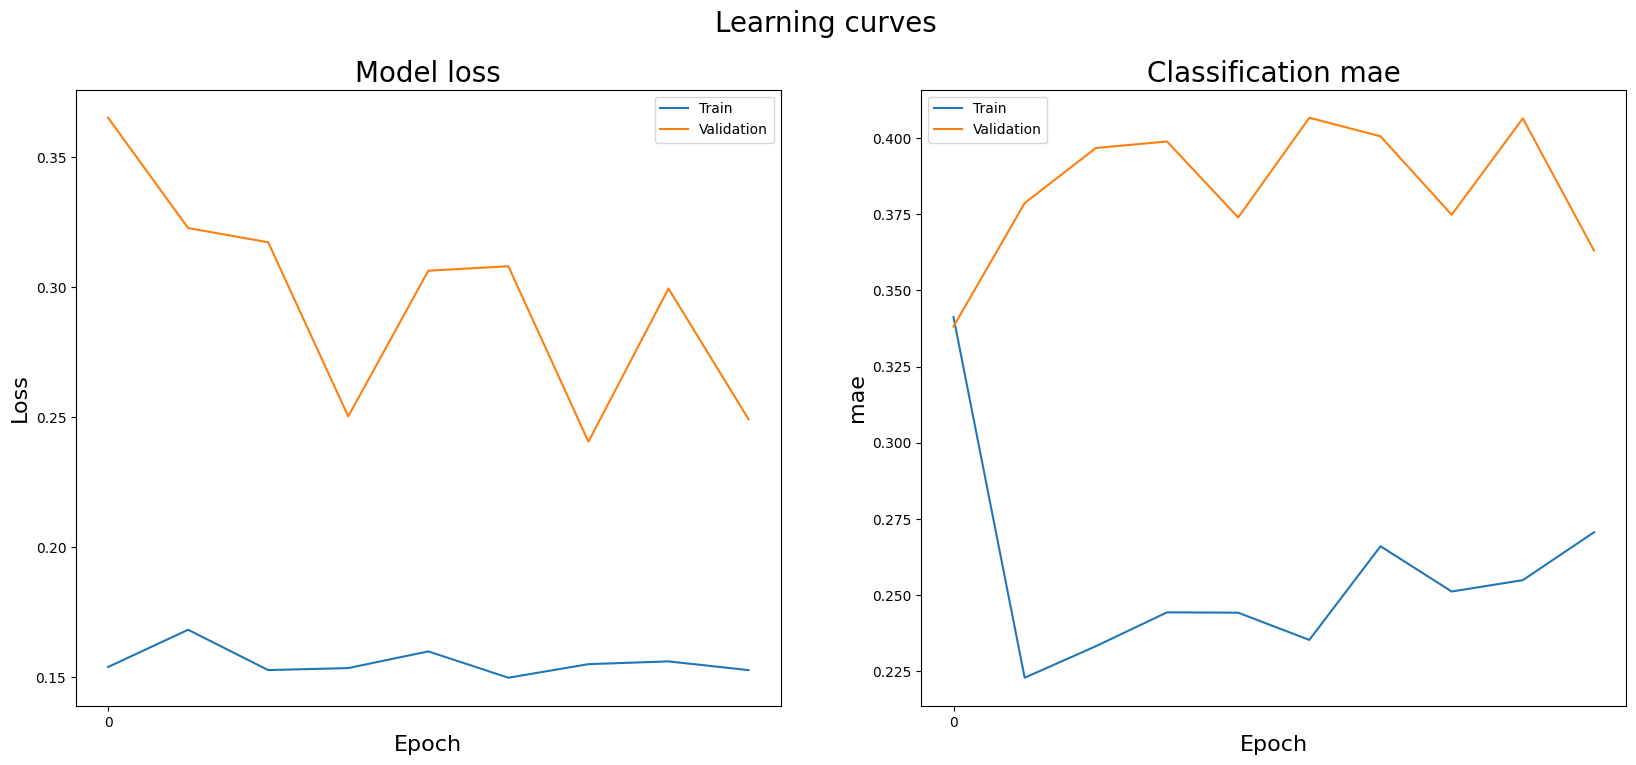

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'][1:])
ax1.plot(history.history['val_loss'][1:])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, epochs+1, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.set_title('Classification mae', size=20)
ax2.set_ylabel('mae', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, epochs+1, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()